In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import BidirectionalLSTMLaneReconstructor,RangeWeightedBCELoss, TrajDataset, FocalLoss
from torch.nn import Unfold

In [3]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2
lane_unit = 200
time_span = 10
hidden_size = 64
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
criterion = FocalLoss()
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug\models"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'lstm_encoder_decoder_bi_h64_t10.pth'
# best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
# best_model.eval()

In [4]:
val_dataset = TrajDataset(data_dir=r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug\val', time_span=time_span)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [7]:
for batch in val_loader:
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    break

In [8]:
pred = best_model(post_occ_X)

In [9]:
criterion(pred, target)

tensor(0.0920, device='cuda:0', grad_fn=<MeanBackward0>)

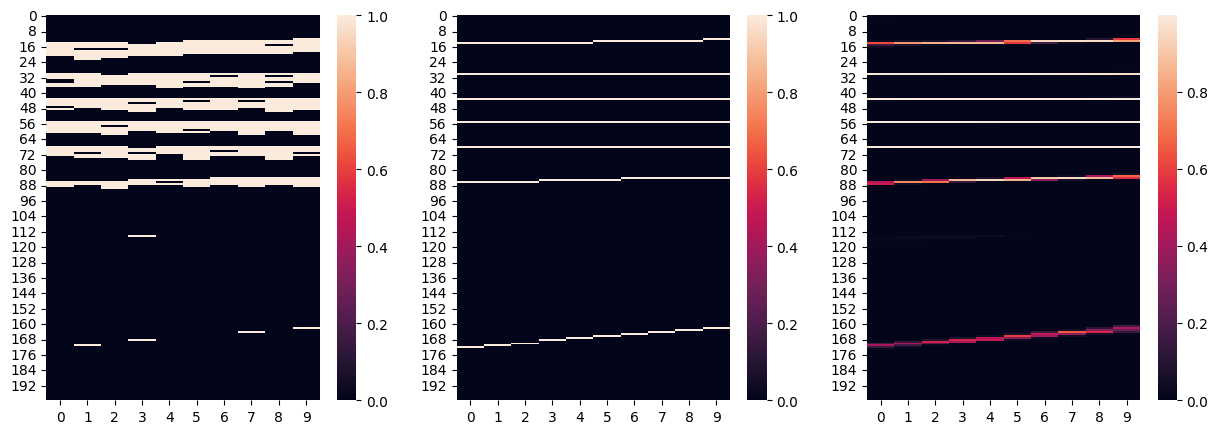

In [294]:
data = val_dataset[96]
post_occ_X = data['post_occ_X']
target = data['target']
output = best_model(post_occ_X.unsqueeze(0).to(device))
numpy_ouput = output.squeeze(0).detach().cpu().numpy()
# post_occ_X.shape
post_occ_X = post_occ_X.squeeze(0).detach().cpu().numpy()
# plot the post_occ_X, target, and output, put the target and post_occ_X in the same plot, output in another plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(post_occ_X, ax=ax[0])
sns.heatmap(target, ax=ax[1])
sns.heatmap(numpy_ouput , ax=ax[2])
plt.show()

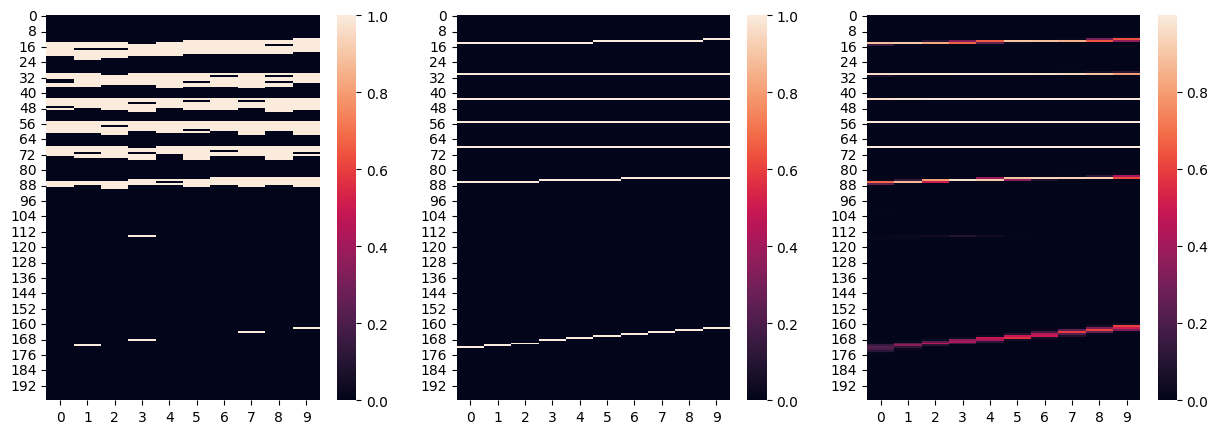

In [296]:
data = val_dataset[96]
post_occ_X = data['post_occ_X']
target = data['target']
output = best_model(post_occ_X.unsqueeze(0).to(device))
numpy_ouput = output.squeeze(0).detach().cpu().numpy()
# post_occ_X.shape
post_occ_X = post_occ_X.squeeze(0).detach().cpu().numpy()
# plot the post_occ_X, target, and output, put the target and post_occ_X in the same plot, output in another plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(post_occ_X, ax=ax[0])
sns.heatmap(target, ax=ax[1])
sns.heatmap(numpy_ouput, ax=ax[2])
plt.show()

In [253]:
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\test.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1

padding = np.zeros((200 - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
test_diagram_unfold = torch.FloatTensor(test_diagram).to(device)
original_shape = test_diagram.shape
stride = 1
test_diagram_unfold = test_diagram_unfold.unfold(1, time_span, stride).permute(1, 0, 2).contiguous()
with torch.no_grad():
    feed_batch = 32
    output = []
    for i in range(0, test_diagram_unfold.size(0), feed_batch):
        output.append(best_model(test_diagram_unfold[i:i+feed_batch]))
    output = torch.cat(output, dim=0)
whole_output = torch.zeros(original_shape).to(device)
for i in range(0, output.size(0), stride):
    whole_output[:,i:i+time_span] += output[i]
whole_output = whole_output.cpu().numpy()

In [39]:
max_weight = 3
num_lane_units = 200
weights = torch.linspace(1, max_weight, num_lane_units)
weights = weights.view(-1, 1)
bce_loss = nn.BCELoss(weight=weights) # Binary Cross-Entropy Loss

In [40]:
pred_test = torch.rand(170, 200, 50)
input_test = torch.rand(170, 200, 50)

In [41]:
test_frame = 3219
test_batch = torch.Tensor(test_diagram[:,test_frame:test_frame + time_span]).unsqueeze(0).to(device)
output = best_model(test_batch)
output = output.squeeze(0).detach().cpu().numpy()

In [212]:
whole_output.max()

99.98916